<h1 style="font-size:2.2em; font-weight:bold; text-align:center;">Exploratory Data Analysis</h1>

This project is a **Proof of Concept (PoC)** for detecting potential financial crime in corporate banking transactions. It demonstrates my interest and capabilities in financial crime detection using synthetic Nordic transaction data and machine learning.

The dataset spans from **April 2, 2025** to **December 31, 2025**, based on the assumption that mid-2025 trade tensions lead to an increase in abnormal or suspicious transaction activity.

For exploratory data analysis (EDA), we will:

- Integrate dynamic currency conversion using the Riksbanken API

- Explore missing values

- Perform univariate and bivariate analysis: Identify potential features related to fraud

- Conduct descriptive analytics using SQL

- Analyze data distribution and identify outliers




## <h2 style="font-size: 1.6em; font-weight: bold;"> 1. Data Collection </h2>
Import Required Packages and Data

**Importing Pandas, Numpy, Matplotlib, Seaborn, Plotly.express and Warings Library.**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

**Import the CSV Data as Pandas DataFrame**

In [2]:
#Import data from 2 reports and merge them using a left join on `from_account_id`

transaction_df = pd.read_csv('data/nordic_transaction_report.csv')
risk_assessment_df = pd.read_csv('data/nordic_AML_KYC_risk_assessment_report.csv')

risk_assessment_df = risk_assessment_df.drop(columns=[col for col in risk_assessment_df.columns if col in transaction_df.columns and col != 'from_account_id'])
df = pd.merge(transaction_df, risk_assessment_df, how='left', on='from_account_id')
df.head()

,transaction_id,transaction_date,booking_date,value_date,payment_date,amount,currency,from_account_id,from_account_name,counterparty_account_id,...,payment_purpose_code,related_trade_invoice_id,swift_message_type,transaction_status,transaction_type_description,end_to_end_identification,is_fraud,from_account_country,from_account_business_type,from_account_expected_turnover
0,1d8bdb66-975b-4441-8b85-b96727eaf2ec,2025-11-06,2025-11-08,2025-11-09,2025-11-11,203701.64,NOK,GB74RNID44875257607090,"Rodriguez, Myers and Giles",GB59UNYK99322750860913,...,Salary,26105f2e-81b8-46f0-ac67-c0214344319d,MT103,pending,Wire Transfer,NaN,0,NO,Consulting,1021011.83
1,84b060bf-10a8-470d-8f8a-509a60c97a82,2025-04-19,2025-04-21,2025-04-21,2025-04-22,427642.34,SEK,GB61JXRV87150476031654,"Hensley, Brandt and Mckenzie",GB06AOZA90321060059678,...,Salary,NaN,MT940,billed,Direct Debit,NaN,0,SE,Textile,1491544.84
2,f94387bf-0550-44bf-a3ab-fd853f9f886c,2025-04-09,2025-04-11,2025-04-11,2025-04-12,464717.51,NOK,GB12IOQU60716165244897,Newton LLC,GB89BCSP82436524967772,...,Salary,NaN,MT202,failed,Card Payment,NaN,0,NO,Textile,1967002.12
3,8185f0fb-960a-4be3-bd7f-11c3169c9ed7,2025-06-12,2025-06-14,2025-06-14,2025-06-15,265887.72,DKK,GB57OMHZ93858433256887,Frye Ltd,GB98VFPC29413119107640,...,Consulting,NaN,MT103,failed,BG-LI-LÖN,a925c79d-7d70-47ae-a691-9e597120bbb9,0,DK,Consulting,1017836.10
4,f27edb54-08cc-4604-ba95-9b36a1bc48d7,2025-07-18,2025-07-20,2025-07-20,2025-07-21,376947.00,NOK,GB23JEMB99152786535417,Contreras-Baker,GB36FLGI40138482504680,...,Unknown,NaN,MT940,billed,Card Payment,NaN,0,NO,Textile,456226.44


In [3]:
df.to_csv('data/RAW_nordic_transactions_with_fraud.csv')

**Dataset Overview**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   transaction_id                  10716 non-null  object 
 1   transaction_date                10716 non-null  object 
 2   booking_date                    10716 non-null  object 
 3   value_date                      10716 non-null  object 
 4   payment_date                    10716 non-null  object 
 5   amount                          10716 non-null  float64
 6   currency                        10716 non-null  object 
 7   from_account_id                 10716 non-null  object 
 8   from_account_name               10716 non-null  object 
 9   counterparty_account_id         10716 non-null  object 
 10  counterparty_name               10242 non-null  object 
 11  counterparty_country            10716 non-null  object 
 12  counterparty_bank_bic           

We have a dataset with 10,716 records and 25 columns:

  - Categorical features: 22

  - Numeric features: 3

## <h2 style="font-size: 1.6em; font-weight: bold;"> 2. Data Wrangling </h2>

- Removed Duplicate Entries

- Converted amounts to EUR using exchange rates from the Riskbanken open API

In [5]:
df.duplicated().sum()

600

The data has 200 duplicate records. Drop all duplicate entries.

In [6]:
#Remove Duplicate
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Converted amounts to EUR to standardize all currencies.

In [7]:
from datetime import datetime, timedelta
import urllib.request, json

# Set up date
single_date = datetime.today() - timedelta(days=1)
date_str = single_date.strftime('%Y-%m-%d')

# Ensure all currency codes are uppercase
currencies = df['currency'].unique()

# Build currency-to-series map
currency_to_series = {
    cur: f'SEK{cur}PMI' if cur != 'SEK' else 'SEK'
    for cur in currencies
}

rate_dict = {}

# Loop to fetch exchange rates
for cur in currencies:
    if cur == 'EUR':
        rate_dict[cur] = 1.0  # EUR to EUR
        continue
    if cur == 'SEK':
        series1 = 'SEK'
    else:
        series1 = currency_to_series[cur]

    series1 = currency_to_series[cur]
    url = f'https://api.riksbank.se/swea/v1/CrossRates/{series1}/SEKEURPMI/{date_str}/{date_str}'

    try:
        req = urllib.request.Request(url)
        req.get_method = lambda: 'GET'
        response = urllib.request.urlopen(req)
        content = response.read()
        data = json.loads(content)

        # Handle different JSON structures
        if isinstance(data, list) and data:
            rate = data[0]['value']
            rate_dict[cur] = float(rate)
        elif isinstance(data, dict) and 'value' in data:
            rate_dict[cur] = float(data['value'])
        else:
            rate_dict[cur] = 1.0

    except Exception as e:
        print(f"Error fetching rate for {cur}: {e}")
        rate_dict[cur] = 1.0

# Apply conversion to EUR
df['amount_eur'] = df.apply(
    lambda x: float(x['amount']) if x['currency'].upper() == 'EUR'
    else (
        float(x['amount']) / rate_dict.get('SEK', 1.0) if x['currency'].upper() == 'SEK'
        else float(x['amount']) * rate_dict.get(x['currency'].upper(), 1.0)
    ),
    axis=1
)

df[['amount', 'currency','amount_eur']]

,amount,currency,amount_eur
0,203701.64,NOK,17684.765280
1,427642.34,SEK,39063.013473
2,464717.51,NOK,40345.380066
3,265887.72,DKK,35642.248866
4,376947.00,NOK,32725.407699
...,...,...,...
10711,95963.60,NOK,8331.271861
10712,202629.40,SEK,18509.193880
10713,388276.43,SEK,35467.132222
10714,230847.17,NOK,20041.458758


## <h2 style="font-size: 1.6em; font-weight: bold;"> 3. EDA </h2>

- Explored missing values.

- Performed univariate and bivariate analysis.

- Performed descriptive analytics using SQL.

- Analyzed data distribution and identified outliers.


**3.1 Missing values**

In [8]:
missing_pct = round(df.isnull().sum()*100/len(df),2)
missing_column_pct = missing_pct[missing_pct> 1]
missing_column_pct

counterparty_name              4.48
narrative                      4.33
related_trade_invoice_id      68.42
end_to_end_identification     47.38
from_account_business_type     2.98
dtype: float64

Let’s examine the relationship between missing values in the columns and the target variable `is_fraud` determine the best way to handle them during Feature Engineering.

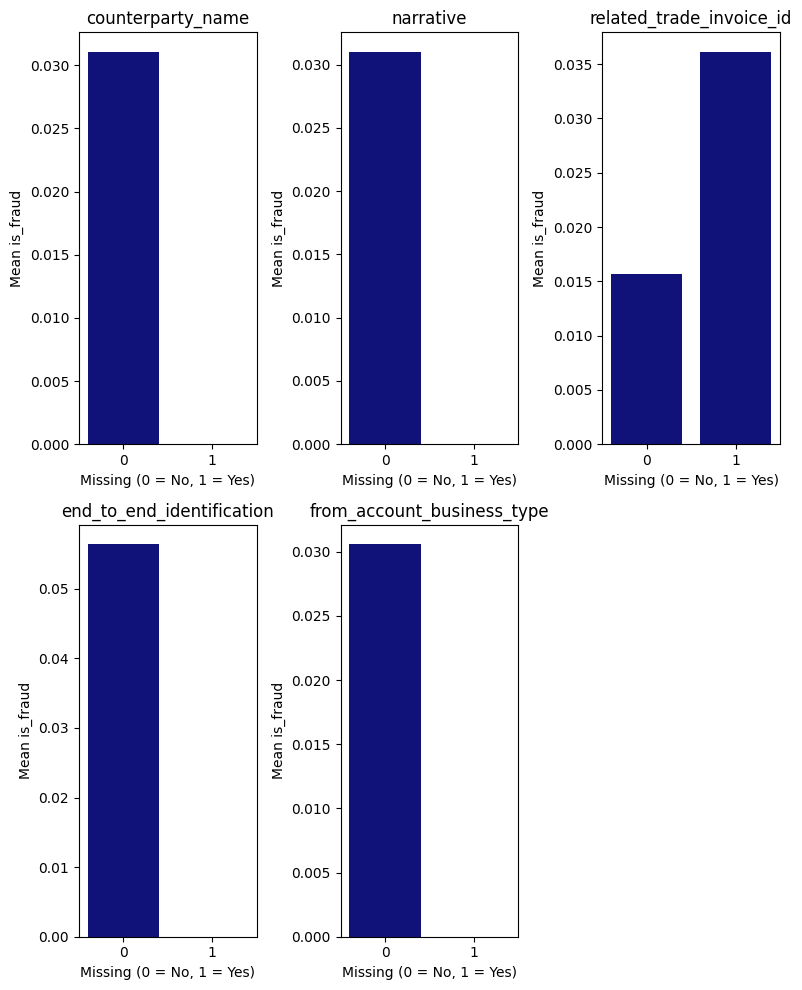

In [9]:
plt.figure(figsize=(8, 10))

for i, col in enumerate(missing_column_pct.index, 1):
    df_copy = df.copy()
    df_copy[col+'_na'] = np.where(df_copy[col].isnull(), 1, 0)
    
    miss = df_copy.groupby(col+'_na')['is_fraud'].mean().reset_index()
    plt.subplot(2, 3, i)
    sns.barplot(data=miss, x=col+'_na', y='is_fraud', color='darkblue')
    plt.title(f'{col}')
    plt.xlabel('Missing (0 = No, 1 = Yes)')
    plt.ylabel('Mean is_fraud')

plt.tight_layout()
plt.show()

So, only `related_trade_invoice_id` shows a relationship with is_fraud; the others can be dropped.

**3.2 Univariate and Bivariate analysis**

**Numeric Features (Continuous Variable)**

In [10]:
numerical_feature = df.select_dtypes (include='number')
numerical_feature.describe()

,amount,is_fraud,from_account_expected_turnover,amount_eur
count,10116.000000,10116.000000,1.011600e+04,10116.000000
mean,243486.162874,0.029656,9.713760e+05,83173.970589
std,146798.675178,0.169645,5.901154e+05,122450.736916
min,165.670000,0.000000,5.012036e+04,15.133135
25%,112214.825000,0.000000,4.450275e+05,17278.842644
50%,241172.625000,0.000000,9.745149e+05,32621.021317
75%,370708.705000,0.000000,1.480447e+06,59478.005575
max,499857.160000,1.000000,1.999913e+06,499748.050000


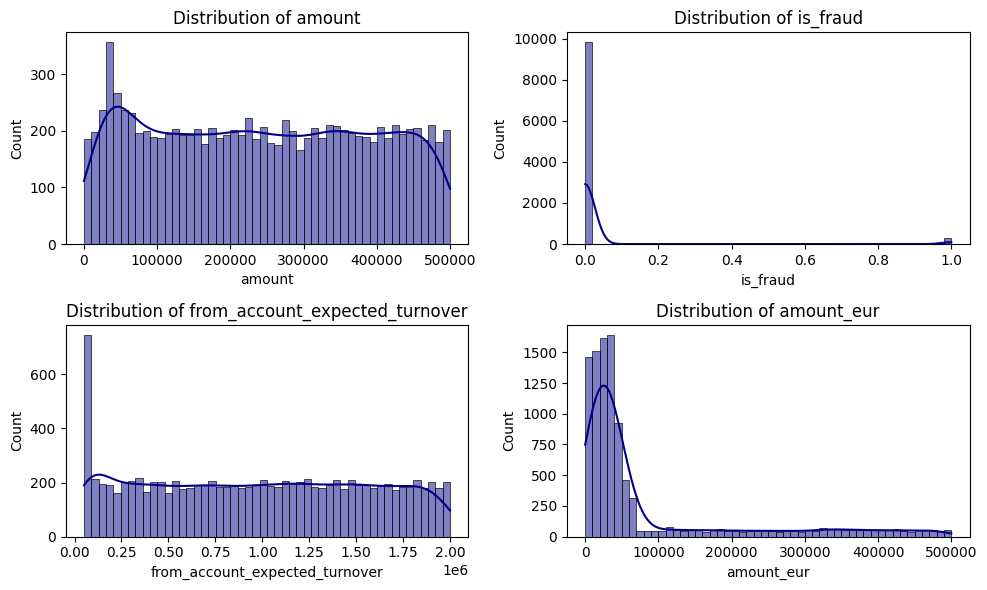

In [11]:
#As we can see, most of the numeric features are continuous variables. Let’s explore them further.
plt.figure(figsize=(10, 6))
for i, col in enumerate(numerical_feature,1):
      df_copy = df.copy()
      plt.subplot(2, 2, i)
      sns.histplot(df_copy[col], bins=50, kde=True, color='darkblue')
      plt.title(f'Distribution of {col}')
      plt.xlabel(col)
      plt.ylabel('Count')

plt.tight_layout()
plt.show()

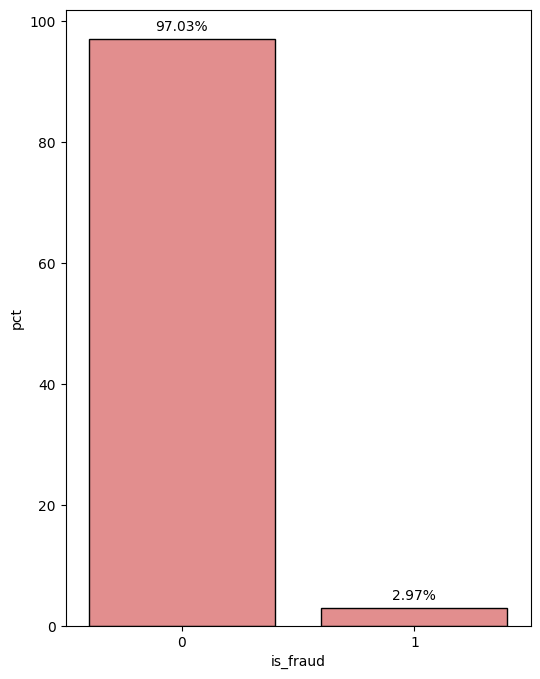

In [12]:
fraud_counts = (100.00* df['is_fraud'].value_counts()/ len(df)).sort_index()
fraud_df = fraud_counts.reset_index()
fraud_df.columns = ['is_fraud','pct']

plt.figure (figsize=(6,8))
ax = sns.barplot(fraud_df, x='is_fraud', y='pct',color='lightcoral', edgecolor='black')

for index,row in fraud_df.iterrows():
    ax.text (x=index, y=row['pct'] + 0.9, s=f"{row['pct']:.2f}%", ha='center', va='bottom')

plt.show()

In [13]:
numerical_feature.corr()['is_fraud'] 

amount                            0.021782
is_fraud                          1.000000
from_account_expected_turnover   -0.265974
amount_eur                        0.120161
Name: is_fraud, dtype: float64

`amount_eur` showed the highest correlation with the target variable.

**Temporal Variables (Ex: Datetime Variables)**

Convert  `transaction_date`, `booking_date`, `value_date`, and `payment_date` from object type to datetime format, then transform them into numeric columns.

In [14]:
df['transaction_day'] = pd.to_datetime(df['transaction_date']).dt.day
df['transaction_day_of_week'] = pd.to_datetime(df['transaction_date']).dt.day_of_week
df['transaction_month'] = pd.to_datetime(df['transaction_date']).dt.month


df['booking_day'] = pd.to_datetime(df['booking_date']).dt.day
df['booking_day_of_week'] = pd.to_datetime(df['booking_day']).dt.day_of_week
df['booking_month'] = pd.to_datetime(df['booking_date']).dt.month


df['value_day'] = pd.to_datetime(df['value_date']).dt.day
df['value_day_of_week'] = pd.to_datetime(df['value_day']).dt.day_of_week
df['value_month'] = pd.to_datetime(df['value_date']).dt.month


df['payment_day'] = pd.to_datetime(df['payment_date']).dt.day
df['payment_day_of_week'] = pd.to_datetime(df['payment_day']).dt.day_of_week
df['payment_month'] = pd.to_datetime(df['payment_date']).dt.month

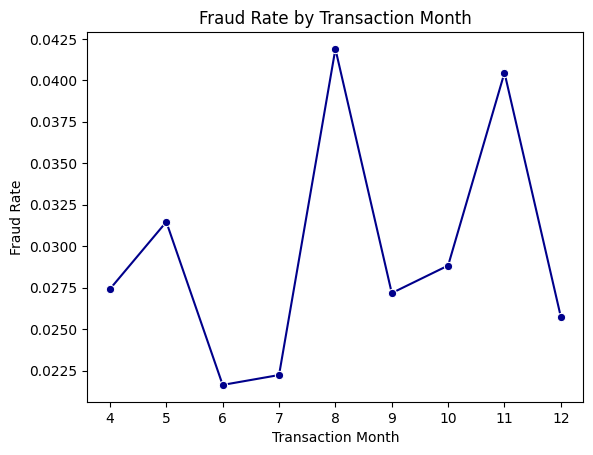

In [15]:
transaction_month = df.groupby(df['transaction_month'])['is_fraud'].mean().reset_index()
sns.lineplot(transaction_month, x='transaction_month', y='is_fraud', marker='o', color='darkblue')
plt.title('Fraud Rate by Transaction Month')
plt.xlabel('Transaction Month')
plt.ylabel('Fraud Rate')
plt.show()

In [16]:
df['transaction_month'].corr(df['is_fraud'])

0.010592139353866695

`transaction_mon` shows a positive Pearson correlation coefficient with `is_fraud`.

**Insight:**

- Fraud rates vary, ranging from about 2.16% to 4.19%.

- August and November show nearly double the fraud rate compared to June.

- The peak in August could be related to increased trade tensions following the expiration of the tariff pause

- Fraud rates hover around 2.5%-3.1%, indicating steady but moderate risk.

**Recommendations:**

- Investigate why months 8 and 11 see spikes in fraud.

- Increase fraud monitoring and controls during high-fraud months.

- Incorporate transaction month as a feature in fraud prediction models.


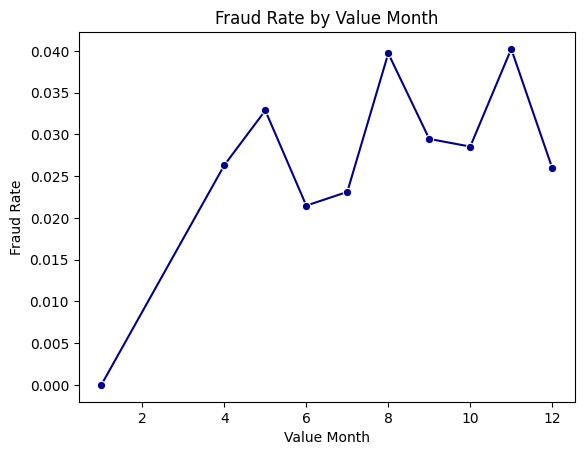

In [17]:
Value_month = df.groupby(df['value_month'])['is_fraud'].mean().reset_index()
sns.lineplot(Value_month, x='value_month', y='is_fraud', marker='o', color='darkblue')
plt.title('Fraud Rate by Value Month')
plt.xlabel('Value Month')
plt.ylabel('Fraud Rate')
plt.show()

In [18]:
df['value_month'].corr(df['is_fraud'])

0.01203919152719998

**Insight**

- Fraud rates begin to rise starting in April, possibly linked to the beginning of trade tensions.

- Peaks occur in August (3.97%) and November (4.02%), aligning with patterns observed in `transaction_month`.

**Recommendations**

- Strengthen fraud detection efforts in August and November, consistent with observed peaks.

- Investigate factors contributing to the increase in fraud beginning in April.

- Integrate both `transaction_mon` and `value_mon` features into predictive models. 


In [19]:
#Let’s analyze the relationship between is_fraud and the other temporal features.
temporal_features = df[[feature for feature in df.columns if 'mon' in feature] + ['is_fraud']]
tem_corr = temporal_features.corr()['is_fraud']
tem_corr

transaction_month    0.010592
booking_month        0.011330
value_month          0.012039
payment_month        0.010434
is_fraud             1.000000
Name: is_fraud, dtype: float64

**Categorical Variables**

In [20]:
categorical_features = df.select_dtypes(include='object')
categorical_features.columns

Index(['transaction_id', 'transaction_date', 'booking_date', 'value_date',
       'payment_date', 'currency', 'from_account_id', 'from_account_name',
       'counterparty_account_id', 'counterparty_name', 'counterparty_country',
       'counterparty_bank_bic', 'counterparty_business_type', 'narrative',
       'payment_purpose_code', 'related_trade_invoice_id',
       'swift_message_type', 'transaction_status',
       'transaction_type_description', 'end_to_end_identification',
       'from_account_country', 'from_account_business_type'],
      dtype='object')

In [21]:
#Identify the number of unique categories in each categorical (object) column.
for feature in categorical_features: 
    count_value = categorical_features[feature].value_counts()
    print (feature,'-', len(count_value),'categories')

transaction_id - 10116 categories
transaction_date - 273 categories
booking_date - 275 categories
value_date - 276 categories
payment_date - 279 categories
currency - 5 categories
from_account_id - 10116 categories
from_account_name - 8776 categories
counterparty_account_id - 10116 categories
counterparty_name - 8377 categories
counterparty_country - 10 categories
counterparty_bank_bic - 4 categories
counterparty_business_type - 5 categories
narrative - 8825 categories
payment_purpose_code - 5 categories
related_trade_invoice_id - 2879 categories
swift_message_type - 3 categories
transaction_status - 3 categories
transaction_type_description - 4 categories
end_to_end_identification - 5323 categories
from_account_country - 4 categories
from_account_business_type - 5 categories


**3.3 Descriptive analytics using SQL**

**Purpose:** From a business perspective, define insights: "what the data tells us?". Broken down into two components:

- Overview of Key Metrics: 

        What are the lowest and highest amounts of fraudulent transactions?

        How many fraud vs. non-fraud transactions and their percentage?
       

- Transaction Trends and Behavior:

       How many transactions were sent inside vs. outside the Nordic region?


In [22]:
!pip install ipython-sql
import sqlite3

# Connect to created in-memory database
con = sqlite3.connect(':memory:')
df.to_sql ('RAW_nordic_transactions_with_fraud', con, index=False)

10116

*What are the lowest and highest amounts of fraudulent transactions?*

In [23]:
query = '''
Select 'lowest_transaction' as category, from_account_name, counterparty_country,currency, amount_eur, is_fraud 
From 
(Select *
From RAW_nordic_transactions_with_fraud
Where is_fraud = '1'
Order by amount_eur asc
Limit 1)

UNION ALL
Select 'highest_transaction' as category, from_account_name, counterparty_country,currency, amount_eur, is_fraud 
From 
(Select *
From RAW_nordic_transactions_with_fraud
Where is_fraud = '1'
Order by amount_eur desc
Limit 1)

'''

df_result = pd.read_sql_query(query, con)
df_result

,category,from_account_name,counterparty_country,currency,amount_eur,is_fraud
0,lowest_transaction,"Watts, Welch and Nunez",RU,SEK,9470.465403,1
1,highest_transaction,"Keith, Hunter and Rodriguez",CN,EUR,496206.170000,1


**Insight:**

- Fraudulent amounts span from low (small test transfers) to high (attempts to extract large sums).
- Both the lowest and highest transaction amounts were sent to high-risk countries, based on sanctions and the 2025 trade tension tariff threats.

*How many fraud vs. non-fraud transactions and their percentage?*

In [24]:
query = '''
Select 
is_fraud, count (*) as transaction_count,
Round (100.00 * COUNT(*) / 10116,2) as percentage
From RAW_nordic_transactions_with_fraud
Group by is_fraud
'''

df_result = pd.read_sql_query (query, con)
df_result

,is_fraud,transaction_count,percentage
0,0,9816,97.03
1,1,300,2.97


**Insight:**   

- Fraud is likely a small percentage (2.97%) compared to 97.03% of non-fraudulent transactions.

*How many transactions were sent inside vs. outside the Nordic region?*

In [25]:
query = '''
Select region, count (*) as transaction_count, 
Round (100* count (*)/ 10116, 2) as percentage
From 
(Select *,
Case when counterparty_country IN ('SE', 'NO', 'FI', 'DK', 'IS') Then 'Nordic' else 'non_Nordic' End as region
From RAW_nordic_transactions_with_fraud
)
Group by region
'''
df_result = pd.read_sql_query (query, con)
df_result

,region,transaction_count,percentage
0,Nordic,4780,47.0
1,non_Nordic,5336,52.0


**Insight:**  

- Transactions are nearly evenly split: 47% from Nordic, 53% from non-Nordic.

- There are slightly more transactions coming from non-Nordic regions than Nordic ones.

**Suggestion:** 

- Segment fraud prevention strategies by region.

**3.4 Outliers and Data Distribution**

As we discovered, most numeric features are skewed. Therefore, we will apply a log transformation to better identify outliers.

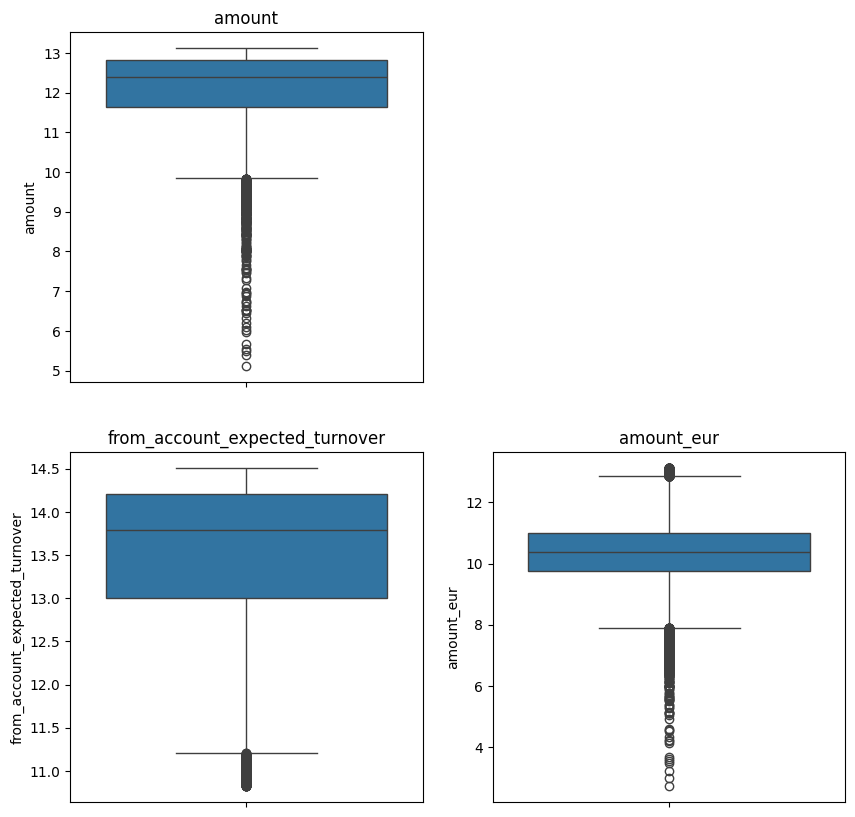

In [26]:
from numpy import log
plt.figure(figsize=(10,10))
for i, col in enumerate(numerical_feature,1):
    df_copy=df.copy()
    if 0 in df_copy[col].unique():
        pass
    else:
        plt.subplot(2, 2, i)
        df_copy[col] = np.log(df_copy[col])
        sns.boxplot(df_copy, y=col)
        plt.title(f'{col}')
plt.show()

As we observed, most of the numeric features contain outliers.

In [27]:
df.head().T

,0,1,2,3,4
transaction_id,1d8bdb66-975b-4441-8b85-b96727eaf2ec,84b060bf-10a8-470d-8f8a-509a60c97a82,f94387bf-0550-44bf-a3ab-fd853f9f886c,8185f0fb-960a-4be3-bd7f-11c3169c9ed7,f27edb54-08cc-4604-ba95-9b36a1bc48d7
transaction_date,2025-11-06,2025-04-19,2025-04-09,2025-06-12,2025-07-18
booking_date,2025-11-08,2025-04-21,2025-04-11,2025-06-14,2025-07-20
value_date,2025-11-09,2025-04-21,2025-04-11,2025-06-14,2025-07-20
payment_date,2025-11-11,2025-04-22,2025-04-12,2025-06-15,2025-07-21
amount,203701.64,427642.34,464717.51,265887.72,376947.0
currency,NOK,SEK,NOK,DKK,NOK
from_account_id,GB74RNID44875257607090,GB61JXRV87150476031654,GB12IOQU60716165244897,GB57OMHZ93858433256887,GB23JEMB99152786535417
from_account_name,"Rodriguez, Myers and Giles","Hensley, Brandt and Mckenzie",Newton LLC,Frye Ltd,Contreras-Baker
counterparty_account_id,GB59UNYK99322750860913,GB06AOZA90321060059678,GB89BCSP82436524967772,GB98VFPC29413119107640,GB36FLGI40138482504680


In [28]:
df.to_csv('data/EDA_nordic_transactions_with_fraud.csv', index=False)